In [2]:
#import image from the computer
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import imageio
from findpeaks import findpeaks
import scipy as sp

volume_properties= []

In [3]:
def count_pixels(saved_masked_img):
    pixel_total_masked = 0
    for i in range(0, saved_masked_img.shape[0]):
        for j in range(0, saved_masked_img.shape[1]):
            if saved_masked_img[i][j][0] != 0:
                pixel_total_masked += 1
    return pixel_total_masked


def thresholding(threshold, historgram):
    pulse_start_end= []
    hist_pulse_area= []
    hist_tr= historgram > threshold
    hist_tr = hist_tr.astype(int)

    hist_total_pulse_area= np.sum(hist_tr)
   # add tolerance to the thresholding
    max_tol= 3
    tol1=0
    tol2=0
    for i in range(1, len(hist_tr)):
        if hist_tr[i] == 1 and hist_tr[i-1] == 0:
            tol1=tol1 + 1
            if tol1==max_tol:
                pulse_start_end.append(i)
                tol1=0
        if hist_tr[i] == 0 and hist_tr[i-1] == 1:
            tol2=tol2 + 1
            if tol2==max_tol:
                pulse_start_end.append(i)
                tol2=0

    for i in range(0, len(pulse_start_end)//2 ):
        hist_pulse_area.append(np.sum(hist_tr[pulse_start_end[2*i]:pulse_start_end[2*i+1]]))
        hist_tr[pulse_start_end[2*i]:pulse_start_end[2*i +1]] = hist_pulse_area[i]
    return hist_tr, hist_pulse_area, pulse_start_end

def make_new_image(rgb_img, mask):
    red = rgb_img[:,:,0]*mask
    green = rgb_img[:,:,1]*mask
    blue = rgb_img[:,:,2]*mask
    masked_img = np.dstack((red,green,blue))
    return masked_img
    

'''plt.subplot(1, 2, 1)
plt.plot(s_threshold, color='g', label="saturation")
plt.title(' Sat')
plt.subplot(1, 2, 2)
plt.plot(v_threshold, color='b', label="value")
plt.title(' Value')
plt.show()'''

'plt.subplot(1, 2, 1)\nplt.plot(s_threshold, color=\'g\', label="saturation")\nplt.title(\' Sat\')\nplt.subplot(1, 2, 2)\nplt.plot(v_threshold, color=\'b\', label="value")\nplt.title(\' Value\')\nplt.show()'

In [4]:
def extract_color(hue_material_number,masked_img, hue, show_graphs=False):
    masked_hsv_img = cv.cvtColor(masked_img, cv.COLOR_RGB2HSV)
    total_pixels_masked= count_pixels(masked_hsv_img)
    if total_pixels_masked <= 15:
        if show_graphs:
            print('invalid material')
        hue_material_number ='N'
        return

    threshold= 100

    s = masked_hsv_img[:,:,1]
    v = masked_hsv_img[:,:,2]

    hist_s = cv.calcHist([s],[0],None,[256],[1,255])
    hist_v = cv.calcHist([v],[0],None,[256],[1,255]) # excluding black background
    
    peaks_s,fp_scipy_s = sp.signal.find_peaks(hist_s.transpose()[0], prominence = 50, distance = 5, wlen=40)
    if (len(fp_scipy_s['prominences'])!=0):
        s_hist_tr, s_hist_pulse_area, s_pulse_start_end= thresholding(threshold, hist_s)
        s_threshold = np.divide( s_hist_tr, total_pixels_masked)
        if len(s_pulse_start_end)<= 2:
            if show_graphs:
                print('there is only one distinct peak in saturation')
            saturation= s_pulse_start_end[0]
        else:
            if show_graphs:
                 print('there are several distinct peaks in saturation')
            hue_material_number ='N'
            # calculate new mask ans apply
            for i in range(0, len(s_pulse_start_end)//2):
                lower_mask = masked_hsv_img[:,:,1] >= s_pulse_start_end[2*i]
                upper_mask = masked_hsv_img[:,:,1] <= s_pulse_start_end[2*i + 1]
                mask = upper_mask*lower_mask
                new_image= make_new_image(masked_img, mask) # for making a rgb image 
                '''plt.figure()
                plt.imshow(new_image)
                plt.title('new image from segmentation')'''
                extract_color(0, new_image, hue,0)


    else:
        if show_graphs: 
             print('invalid material Saturation')
        hue_material_number ='N'
    
    
    peaks_v,fp_scipy_v = sp.signal.find_peaks(hist_v.transpose()[0], prominence = 50, distance = 5, wlen=40)
    if (len(fp_scipy_v['prominences'])!=0):
        v_hist_tr, v_hist_pulse_area, v_pulse_start_end= thresholding(threshold, hist_v)
        v_hist_tr = np.divide( v_hist_tr, total_pixels_masked)
        value= peaks_v[-1]

    else:
        if show_graphs:
            print('invalid material Value')
        hue_material_number= 'N'
    

    if(show_graphs and hue_material_number !='N'):
        
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.plot(hist_s, color='g', label="saturation")
        plt.scatter(peaks_s, hist_s[peaks_s], color='r')
        plt.title(' Sat')

        plt.subplot(1, 2, 2)
        plt.plot(hist_v, color='b', label="value")
        plt.scatter(peaks_v, hist_v[peaks_v], color='g')
        plt.title(' Value ')
        plt.show()

        # show the color with different V and S
        color_prominence= np.ones((250,250,3))

        color_prominence[:,:,0]= hue
        for i in range(0,250):
            color_prominence[:,i,1]= color_prominence[:,i,1]* i #S
            color_prominence[i,:,2]= color_prominence[i,:,2]* (250-i) # V

        color_prominence = cv.convertScaleAbs(color_prominence)
        color_prominence_RGB = cv.cvtColor(color_prominence, cv.COLOR_HSV2RGB)
        plt.figure()
        plt.imshow(color_prominence_RGB)
        plt.xlabel('Increasing Saturation --> ')
        plt.ylabel('Increasing Value -->')
        plt.title('The extracted color of the object')
        
    if hue_material_number !='N':

        final_color=np.ones((50,50,3))
        final_color[:,:,0]=  hue
        final_color[:,:,1]=  saturation
        final_color[:,:,2]=  value 
        final_color = cv.convertScaleAbs(final_color)
        final_color_RGB = cv.cvtColor(final_color, cv.COLOR_HSV2RGB)
    
        if show_graphs:
            plt.figure()
            plt.subplot(1, 2, 1) # row 1, col 2 index 1
            plt.imshow(masked_img)
        
            plt.subplot(1, 2, 2) # index 2
            plt.imshow(final_color_RGB)
            plt.title('Final color of object')


        if show_graphs:
            print('number of pixels', total_pixels_masked,', HSV', hue, saturation,value)
    
        material_color_hsv= np.uint8([[[hue,saturation,value]]])  
        material_color_rgb = cv.cvtColor(material_color_hsv, cv.COLOR_HSV2RGB)
        # mat_number, where it acts, rgb alpha, enabled?
        volume_properties.append([total_pixels_masked,0,material_color_rgb[0][0][0], material_color_rgb[0][0][1], material_color_rgb[0][0][2], 255, 1])


In [7]:
def hsv_analysis(rgb_img,show_graphs= False):
    
    hsv_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)

    pixel_total= hsv_img.shape[0]*hsv_img.shape[1]
    saved_masked_img= rgb_img

    h = hsv_img[:,:,0]
    hist_h = cv.calcHist([h],[0],None,[256],[0,256])

    peaks,fp_scipy = sp.signal.find_peaks(hist_h.transpose()[0], prominence = 500, distance = 5, wlen=40)

    print('There are ',len(fp_scipy['prominences']),'Hue peaks')
    for hue_material_number in range(len(fp_scipy['prominences'])):

        #mask for object segmentation
        lower_mask = hsv_img[:,:,0] > fp_scipy['left_bases'][hue_material_number] 
        upper_mask = hsv_img[:,:,0] < fp_scipy['right_bases'][hue_material_number]
        mask = upper_mask*lower_mask

        #show segmented image
        red = rgb_img[:,:,0]*mask
        green = rgb_img[:,:,1]*mask
        blue = rgb_img[:,:,2]*mask
        masked_img = np.dstack((red,green,blue))
        extract_color(hue_material_number, masked_img, peaks[hue_material_number],show_graphs)
    return saved_masked_img

Using the algorythm 

There are  12 Hue peaks
volume properties [[12946, 0, 253, 249, 248, 255, 1], [1356, 0, 230, 214, 209, 255, 1], [18499, 0, 151, 42, 9, 255, 1], [1404, 0, 240, 237, 235, 255, 1], [1757, 0, 253, 248, 244, 255, 1], [709, 0, 233, 226, 221, 255, 1], [300, 0, 229, 220, 214, 255, 1], [134, 0, 230, 220, 212, 255, 1], [6698, 0, 250, 249, 248, 255, 1], [413, 0, 253, 250, 244, 255, 1], [490, 0, 250, 246, 238, 255, 1], [68715, 0, 253, 253, 252, 255, 1], [488, 0, 233, 230, 206, 255, 1], [230, 0, 228, 221, 161, 255, 1], [16347, 0, 254, 246, 177, 255, 1], [12144, 0, 254, 241, 127, 255, 1], [71039, 0, 251, 234, 84, 255, 1], [2415, 0, 251, 252, 248, 255, 1], [1888, 0, 232, 233, 230, 255, 1], [687, 0, 102, 128, 76, 255, 1], [201, 0, 102, 129, 75, 255, 1], [3745, 0, 84, 108, 60, 255, 1], [1580, 0, 76, 102, 51, 255, 1], [653, 0, 75, 101, 48, 255, 1], [14356, 0, 247, 248, 247, 255, 1], [173, 0, 121, 154, 104, 255, 1], [277, 0, 118, 152, 101, 255, 1], [476, 0, 115, 150, 98, 255, 1], [1094, 0, 112, 147, 94, 

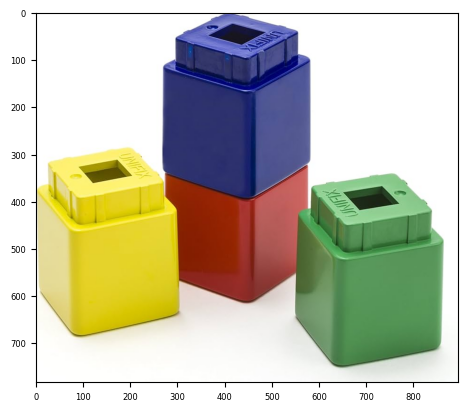

In [80]:
volume_properties= []
rgb_img = imageio.imread("photos/coloured_cubes_sample.jpg")
plt.imshow(rgb_img)

saved_masked_img=hsv_analysis(rgb_img, 0)

print('volume properties', volume_properties)

there are  10  materials
volume properties [[33658, 0, 152, 206, 154, 255, 1], [23821, 0, 231, 213, 52, 255, 1], [16605, 0, 73, 78, 147, 255, 1], [11687, 0, 117, 122, 193, 255, 1], [6413, 0, 145, 38, 6, 255, 1], [3273, 0, 254, 241, 124, 255, 1], [3130, 0, 230, 223, 159, 255, 1], [2862, 0, 51, 102, 53, 255, 1], [360, 0, 41, 45, 110, 255, 1], [333, 0, 229, 221, 148, 255, 1]]


IndexError: list index out of range

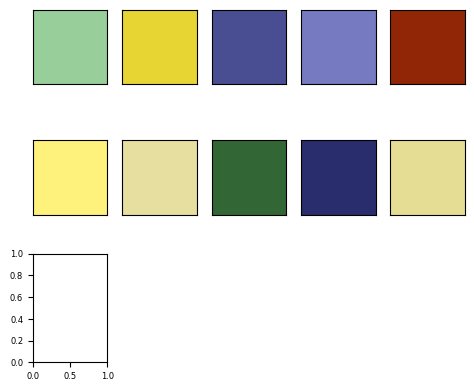

In [75]:
#solume properties by number of pixels

def print_color(r,g,b):
    final_color=np.ones((30,30,3))
    final_color[:,:,0]=  r
    final_color[:,:,1]=  g
    final_color[:,:,2]=  b 
    #stack 
    final_color = cv.convertScaleAbs(final_color)
    return final_color
    
def show_vp(volume_properties, top=len(volume_properties), show=0):
    plt.figure()
    for i in range(0,top):
        #divide by 5 and round up
        plt.subplot(len(volume_properties)//5 +1, 5, i+1)
        color_image = print_color(volume_properties[i][2],volume_properties[i][3],volume_properties[i][4])
        plt.imshow(color_image)
        if show:
            plt.title(str(volume_properties[i][0])+ ',\n rgb: '+ str(volume_properties[i][2])+','+str(volume_properties[i][3])+','+str(volume_properties[i][4]))
        #dont show axis
        plt.xticks([])
        plt.yticks([])
        #make titles small
        plt.rcParams.update({'font.size': 6})
        #title to the right of image
        plt.subplots_adjust(right=0.8)
        #make break between images
        #plt.subplots_adjust(hspace=2.5)
        #plt.subplots_adjust(wspace=0.5)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties, top=30)

plt.figure()
plt.imshow(rgb_img)
    

There are  4 Hue peaks
there are  9  materials
volume properties [[5464, 0, 254, 221, 7, 255, 1], [2187, 0, 254, 51, 37, 255, 1], [1967, 0, 5, 100, 224, 255, 1], [1256, 0, 3, 163, 72, 255, 1], [1020, 0, 191, 62, 53, 255, 1], [239, 0, 59, 102, 159, 255, 1], [185, 0, 61, 104, 160, 255, 1], [158, 0, 191, 53, 43, 255, 1], [109, 0, 254, 254, 253, 255, 1]]


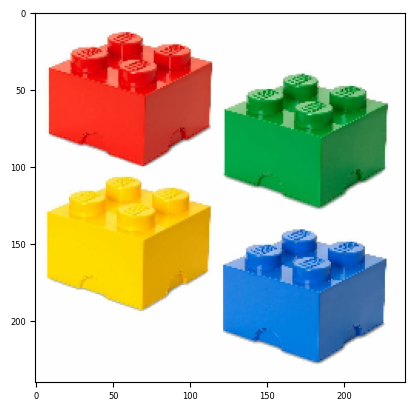

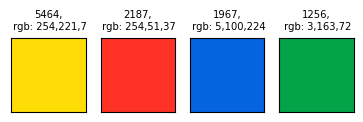

In [67]:
volume_properties= []
rgb_img = imageio.imread("photos/lego_sample.png")
plt.imshow(rgb_img)

saved_masked_img=hsv_analysis(rgb_img, 0)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties, 4 )

There are  13 Hue peaks
there are  43  materials
volume properties [[160636, 0, 242, 241, 241, 255, 1], [71079, 0, 226, 216, 217, 255, 1], [67517, 0, 251, 251, 252, 255, 1], [49662, 0, 223, 220, 220, 255, 1], [45291, 0, 251, 250, 253, 255, 1], [18177, 0, 252, 250, 253, 255, 1], [11774, 0, 108, 54, 72, 255, 1], [8290, 0, 67, 67, 134, 255, 1], [8140, 0, 162, 143, 180, 255, 1], [5208, 0, 229, 226, 230, 255, 1], [4260, 0, 80, 8, 32, 255, 1], [3628, 0, 3, 3, 8, 255, 1], [3074, 0, 0, 1, 1, 255, 1], [2305, 0, 91, 50, 45, 255, 1], [1959, 0, 110, 93, 86, 255, 1], [1913, 0, 1, 1, 13, 255, 1], [1862, 0, 193, 177, 172, 255, 1], [1765, 0, 223, 216, 213, 255, 1], [1229, 0, 92, 53, 49, 255, 1], [915, 0, 114, 92, 84, 255, 1], [884, 0, 7, 1, 3, 255, 1], [524, 0, 1, 1, 9, 255, 1], [512, 0, 1, 1, 11, 255, 1], [478, 0, 1, 1, 7, 255, 1], [371, 0, 3, 1, 3, 255, 1], [365, 0, 2, 2, 11, 255, 1], [348, 0, 5, 1, 2, 255, 1], [335, 0, 3, 3, 10, 255, 1], [310, 0, 2, 1, 9, 255, 1], [305, 0, 3, 2, 11, 255, 1], [298, 

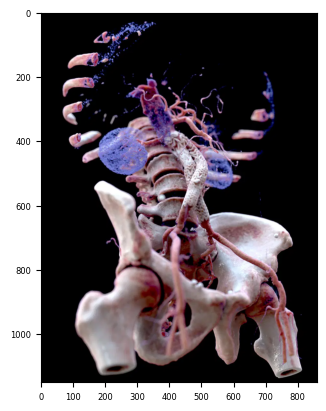

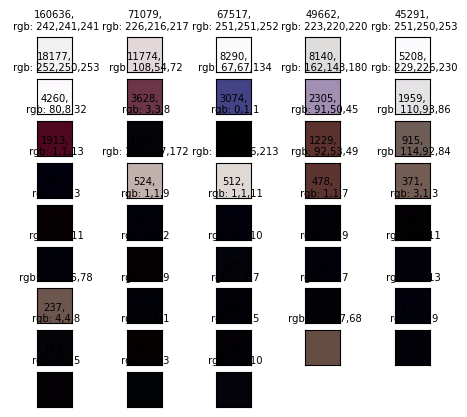

In [63]:
volume_properties= []
rgb_img = imageio.imread("photos/pretty_image.png")
plt.imshow(rgb_img)

saved_masked_img=hsv_analysis(rgb_img, 0)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties,top=10)

There are  1 Hue peaks
there is only one distinct peak in saturation


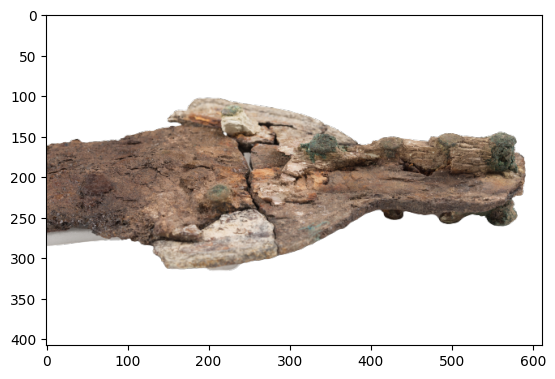

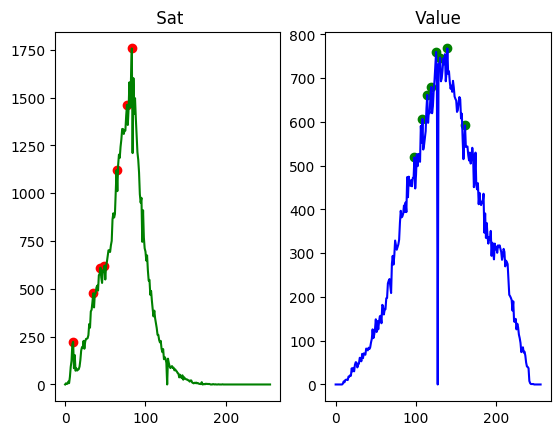

number of pixels 80294 , HSV 12 19 161
there are  1  materials
volume properties [[80294, 0, 161, 154, 149, 255, 1]]


NameError: name 'show_vp' is not defined

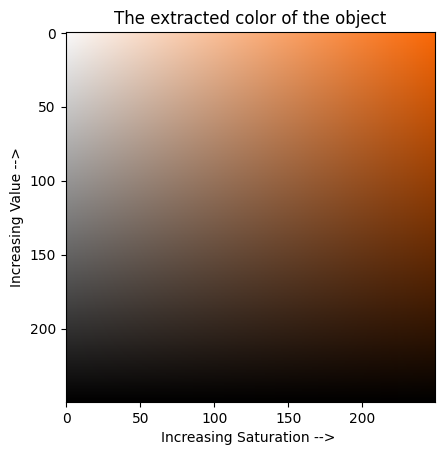

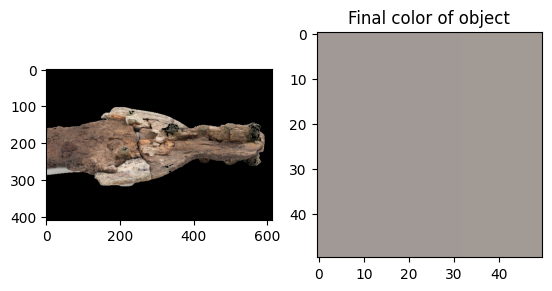

In [8]:
volume_properties= []
rgb_img = imageio.imread("photos/very_old_sword-removebg-preview.png")
plt.imshow(rgb_img)

hsv_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)

pixel_total= hsv_img.shape[0]*hsv_img.shape[1]
saved_masked_img= rgb_img

h = hsv_img[:,:,0]
    hist_h = cv.calcHist([h],[0],None,[256],[0,256])

    peaks,fp_scipy = sp.signal.find_peaks(hist_h.transpose()[0], prominence = 500, distance = 5, wlen=40)

saved_masked_img=hsv_analysis(rgb_img, 1)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties)

There are  7 Hue peaks
there are  6  materials
volume properties [[66894, 0, 83, 98, 88, 255, 1], [53449, 0, 49, 99, 66, 255, 1], [21445, 0, 93, 92, 91, 255, 1], [4038, 0, 146, 147, 143, 255, 1], [3493, 0, 147, 150, 148, 255, 1], [2640, 0, 147, 149, 145, 255, 1]]


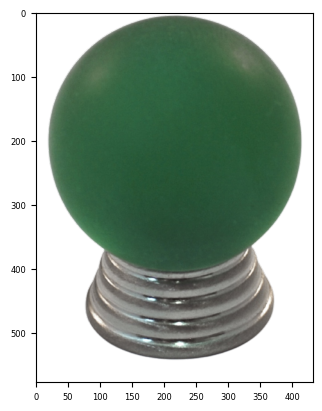

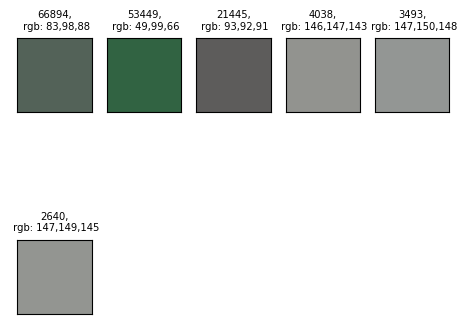

In [65]:

volume_properties= []
rgb_img = imageio.imread("photos/materials_sample-removebg-preview.png")
plt.imshow(rgb_img)

saved_masked_img=hsv_analysis(rgb_img, 0)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties)

There are  4 Hue peaks
there are  10  materials
volume properties [[33658, 0, 152, 206, 154, 255, 1], [23821, 0, 231, 213, 52, 255, 1], [16605, 0, 73, 78, 147, 255, 1], [11687, 0, 117, 122, 193, 255, 1], [6413, 0, 145, 38, 6, 255, 1], [3273, 0, 254, 241, 124, 255, 1], [3130, 0, 230, 223, 159, 255, 1], [2862, 0, 51, 102, 53, 255, 1], [360, 0, 41, 45, 110, 255, 1], [333, 0, 229, 221, 148, 255, 1]]


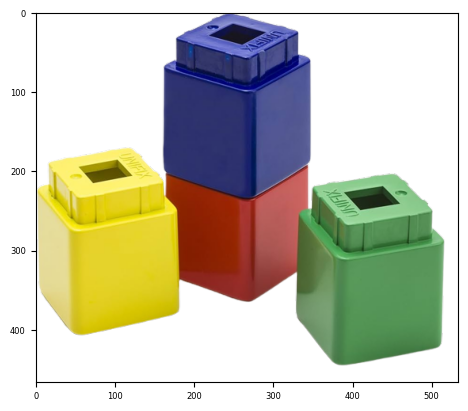

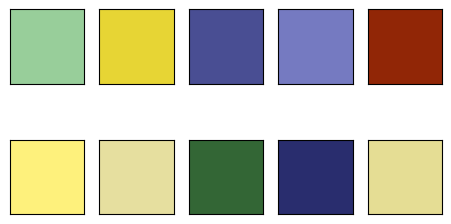

In [76]:
volume_properties= []
rgb_img = imageio.imread("photos/coloured_cubes_sample-removebg-preview.png")
plt.imshow(rgb_img)

saved_masked_img=hsv_analysis(rgb_img, 0)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties)

There are  4 Hue peaks
there are  11  materials
volume properties [[18514, 0, 96, 159, 98, 255, 1], [10611, 0, 228, 210, 48, 255, 1], [8672, 0, 47, 51, 107, 255, 1], [7273, 0, 116, 121, 193, 255, 1], [4286, 0, 215, 195, 14, 255, 1], [2786, 0, 144, 36, 3, 255, 1], [2049, 0, 51, 55, 103, 255, 1], [1947, 0, 227, 219, 151, 255, 1], [1640, 0, 252, 238, 117, 255, 1], [1361, 0, 49, 99, 51, 255, 1], [1267, 0, 111, 154, 113, 255, 1]]


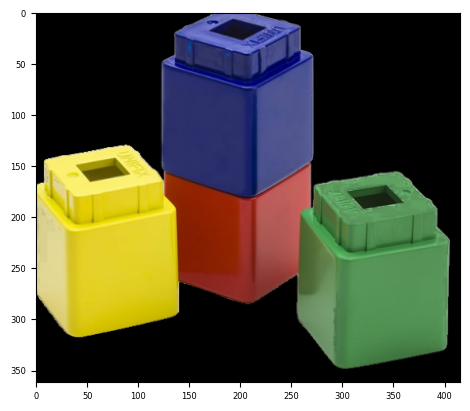

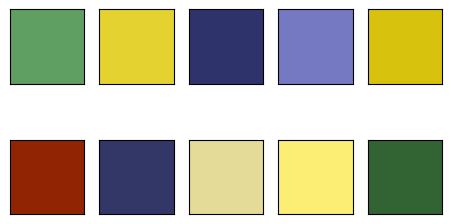

In [77]:
volume_properties= []
rgb_img = imageio.imread("photos/diffuse09.png")
plt.imshow(rgb_img)

saved_masked_img=hsv_analysis(rgb_img, 0)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties)

There are  4 Hue peaks
there are  10  materials
volume properties [[17997, 0, 84, 147, 86, 255, 1], [10612, 0, 228, 210, 48, 255, 1], [8681, 0, 47, 51, 107, 255, 1], [7140, 0, 83, 87, 146, 255, 1], [5555, 0, 252, 239, 118, 255, 1], [4287, 0, 215, 195, 14, 255, 1], [2786, 0, 144, 36, 3, 255, 1], [2059, 0, 51, 55, 103, 255, 1], [1793, 0, 110, 153, 111, 255, 1], [1391, 0, 49, 99, 51, 255, 1]]


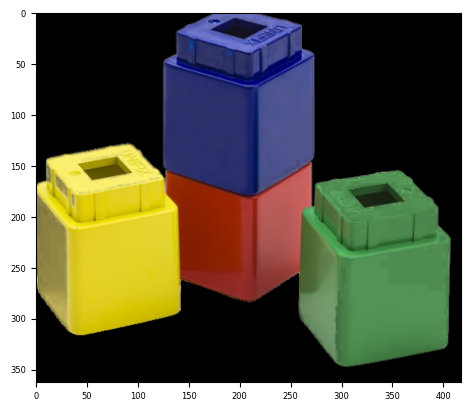

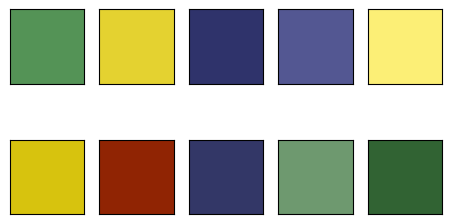

In [78]:
volume_properties= []
rgb_img = imageio.imread("photos/diffuse07.png")
plt.imshow(rgb_img)

saved_masked_img=hsv_analysis(rgb_img, 0)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties)

There are  4 Hue peaks
there are  11  materials
volume properties [[17507, 0, 74, 136, 76, 255, 1], [10725, 0, 228, 210, 48, 255, 1], [8684, 0, 47, 51, 107, 255, 1], [7083, 0, 78, 82, 145, 255, 1], [6748, 0, 191, 177, 50, 255, 1], [4305, 0, 215, 195, 14, 255, 1], [2786, 0, 144, 36, 3, 255, 1], [2235, 0, 85, 131, 87, 255, 1], [2123, 0, 51, 55, 103, 255, 1], [1426, 0, 49, 99, 51, 255, 1], [220, 0, 65, 67, 102, 255, 1]]


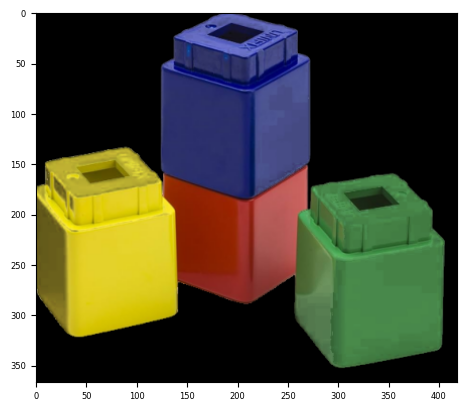

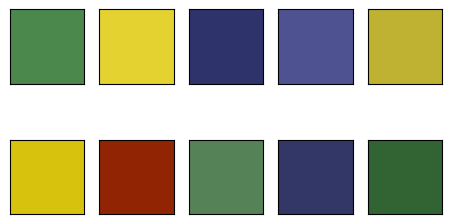

In [79]:
volume_properties= []
rgb_img = imageio.imread("photos/diffuse05.png")
plt.imshow(rgb_img)

saved_masked_img=hsv_analysis(rgb_img, 0)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties)